In [84]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('../data/nfp2/nfp2.db')  # Adjust the path to your database file

# Step 2 & 3: Query the database and load the data into a pandas DataFrame
query = "SELECT * FROM stellarators"  # Adjust your query as needed
data_df = pd.read_sql_query(query, conn)

In [85]:
from sklearn.model_selection import train_test_split, GridSearchCV

data_df_clean = data_df.dropna(subset=['quasisymmetry'])

X = data_df_clean[['rbc_1_0', 'rbc_m1_1', 'rbc_0_1', 'rbc_1_1','zbs_1_0', 'zbs_m1_1', 'zbs_0_1', 'zbs_1_1']] 
Y = data_df_clean[['quasisymmetry', 'quasiisodynamic', 'rotational_transform', 'inverse_aspect_ratio', 'mean_local_magnetic_shear', 'vacuum_magnetic_well', 'maximum_elongation', 'mirror_ratio']]

target = X['rbc_1_0']
features = X.drop('rbc_1_0', axis=1)

quasisymmetry_df = pd.DataFrame(Y['quasisymmetry'])

features = pd.concat([features, quasisymmetry_df], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print(features.shape)


(140201, 8)


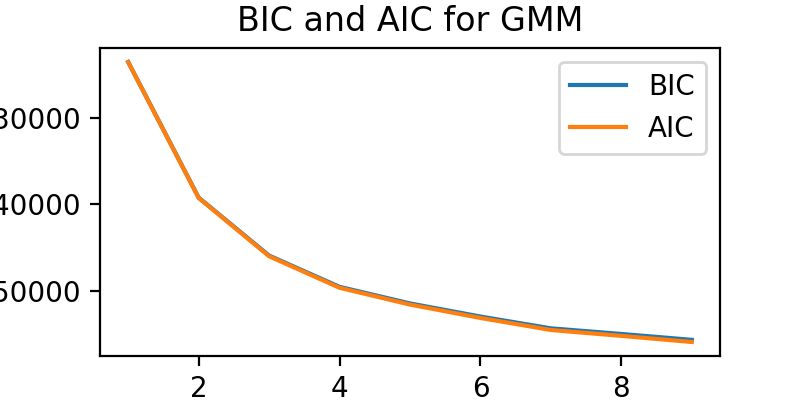

Selected Model Components: 9


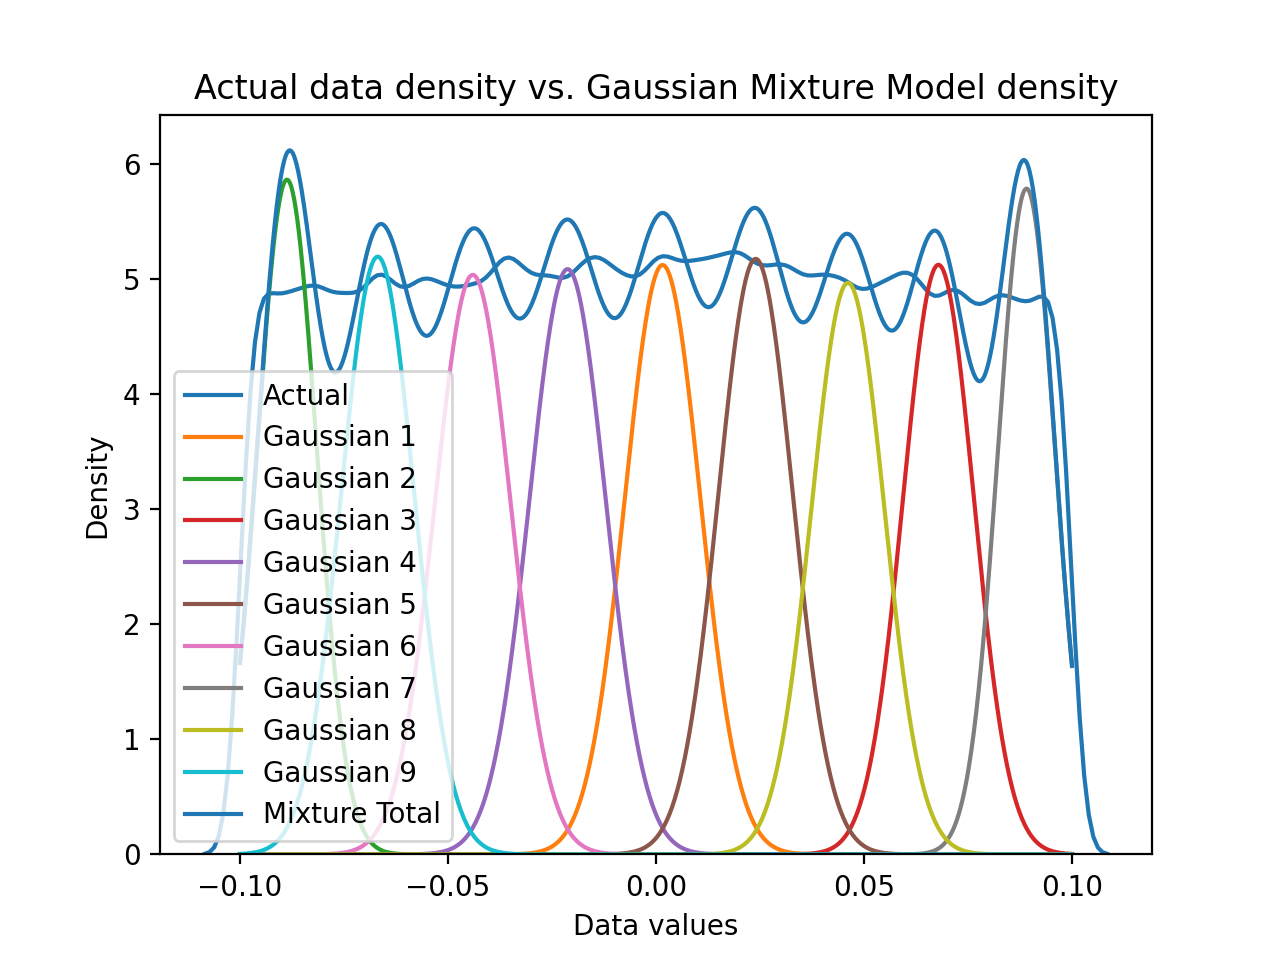

In [86]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

# Assuming `Y_train_np` is your 1D numpy array data
Y_train_np = Y_train.to_numpy().reshape(-1, 1)  # Reshape to 2D if necessary

# Use AIC and BIC to determine the best number of components for GMM
n_components_range = range(1, 10)  # Example range, can be adjusted
lowest_bic = np.infty
lowest_aic = np.infty
best_gmm = None
bic = []
aic = []

for n_components in n_components_range:
    # Fit a Gaussian mixture with n components
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(Y_train_np)
    
    # Calculate the BIC and AIC
    bic.append(gmm.bic(Y_train_np))
    aic.append(gmm.aic(Y_train_np))
    
    # Determine if this model has the lowest BIC
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm_bic = gmm
        
    # Determine if this model has the lowest AIC
    if aic[-1] < lowest_aic:
        lowest_aic = aic[-1]
        best_gmm_aic = gmm

# Plot the BIC scores
plt.figure(figsize=(4, 2))
plt.plot(n_components_range, bic, label='BIC')
plt.plot(n_components_range, aic, label='AIC')
plt.legend()
plt.xlabel('Number of Components')
plt.ylabel('Criterion Value')
plt.title('BIC and AIC for GMM')
plt.show()

# Use the best model for the final density plot
best_gmm = best_gmm_bic if lowest_bic < lowest_aic else best_gmm_aic
print(f"Selected Model Components: {best_gmm.n_components}")

# Generate some data points for plotting the density
x = np.linspace(Y_train_np.min(), Y_train_np.max(), 1000).reshape(-1, 1)
logprob = best_gmm.score_samples(x)
responsibilities = best_gmm.predict_proba(x)
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

# Plot the actual kernel density estimation of your data
sns.kdeplot(Y_train_np.flatten(), bw_adjust=0.5, label='Actual')

# Plot each component density
for i in range(best_gmm.n_components):
    plt.plot(x, pdf_individual[:, i], label=f'Gaussian {i+1}')

# Plot the total density
plt.plot(x, pdf, label='Mixture Total')

plt.legend()
plt.title('Actual data density vs. Gaussian Mixture Model density')
plt.xlabel('Data values')
plt.ylabel('Density')
plt.show()


Fitting of candidate distributions completed: 100%|██████████| 8/8 [00:35<00:00,  4.44s/it]


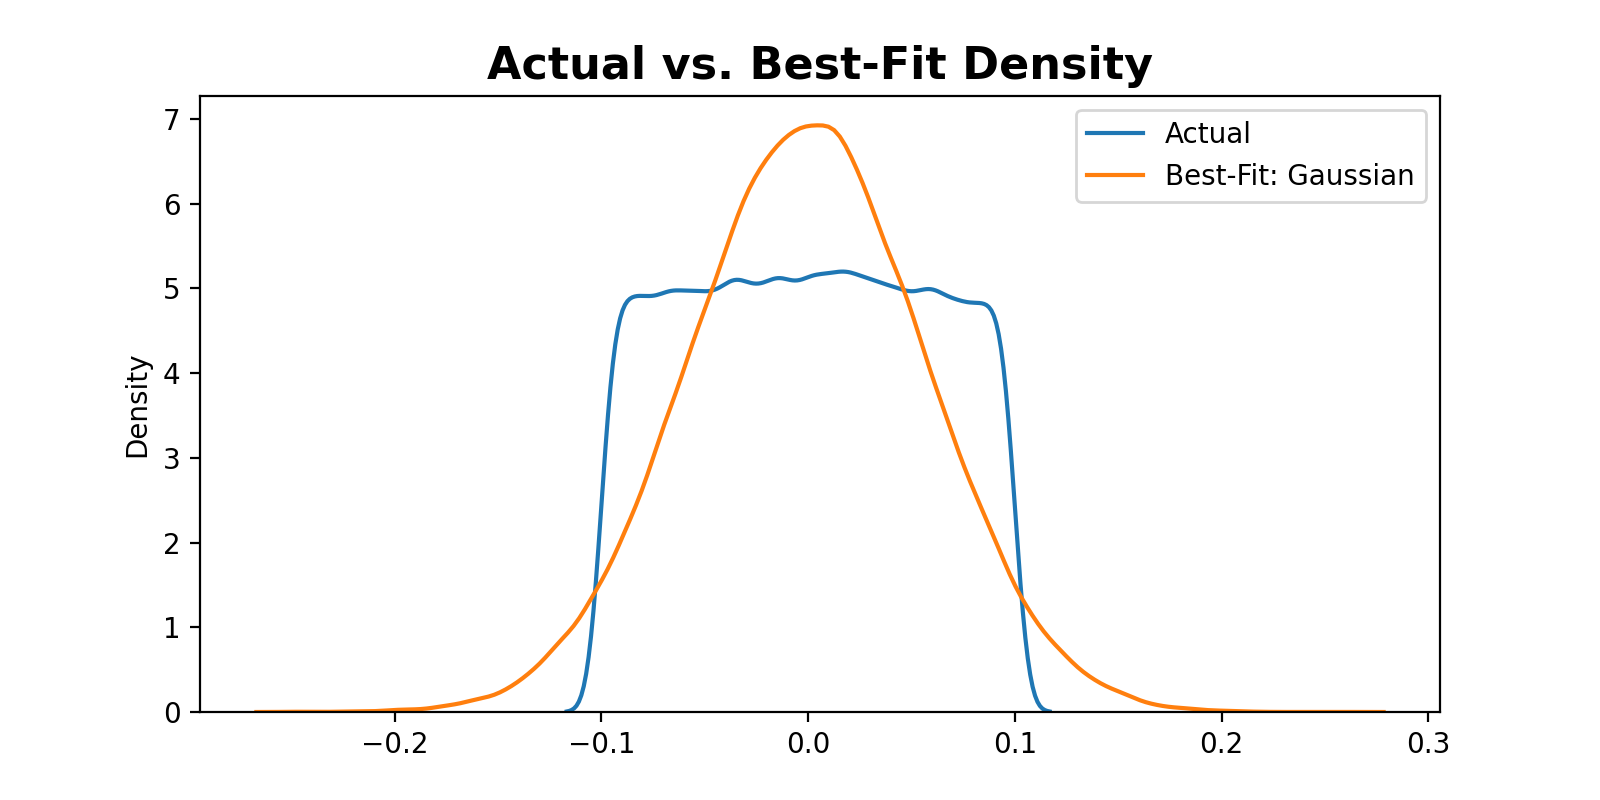

nll distribution
rank                           
1    -1.617478e+05     Gaussian
2    -1.616397e+05     StudentT
3    -1.582036e+05       Gumbel
4    -1.474654e+05      Laplace
5    -1.295729e+05       Cauchy
6    -1.171865e+05        Gamma
7    -5.729522e+04      Weibull
8     1.583985e+06    LogNormal

In [87]:
from lightgbmlss.distributions import *
from lightgbmlss.distributions.distribution_utils import DistributionClass
import numpy as np

Y_train_np = np.array(Y_train)

lgblss_dist_class = DistributionClass()
candidate_distributions = [Gaussian, StudentT, Gamma, Cauchy, LogNormal, Weibull, Gumbel, Laplace]

dist_nll = lgblss_dist_class.dist_select(target=Y_train_np, candidate_distributions=candidate_distributions, max_iter=50, plot=True, figure_size=(8, 4))
dist_nll

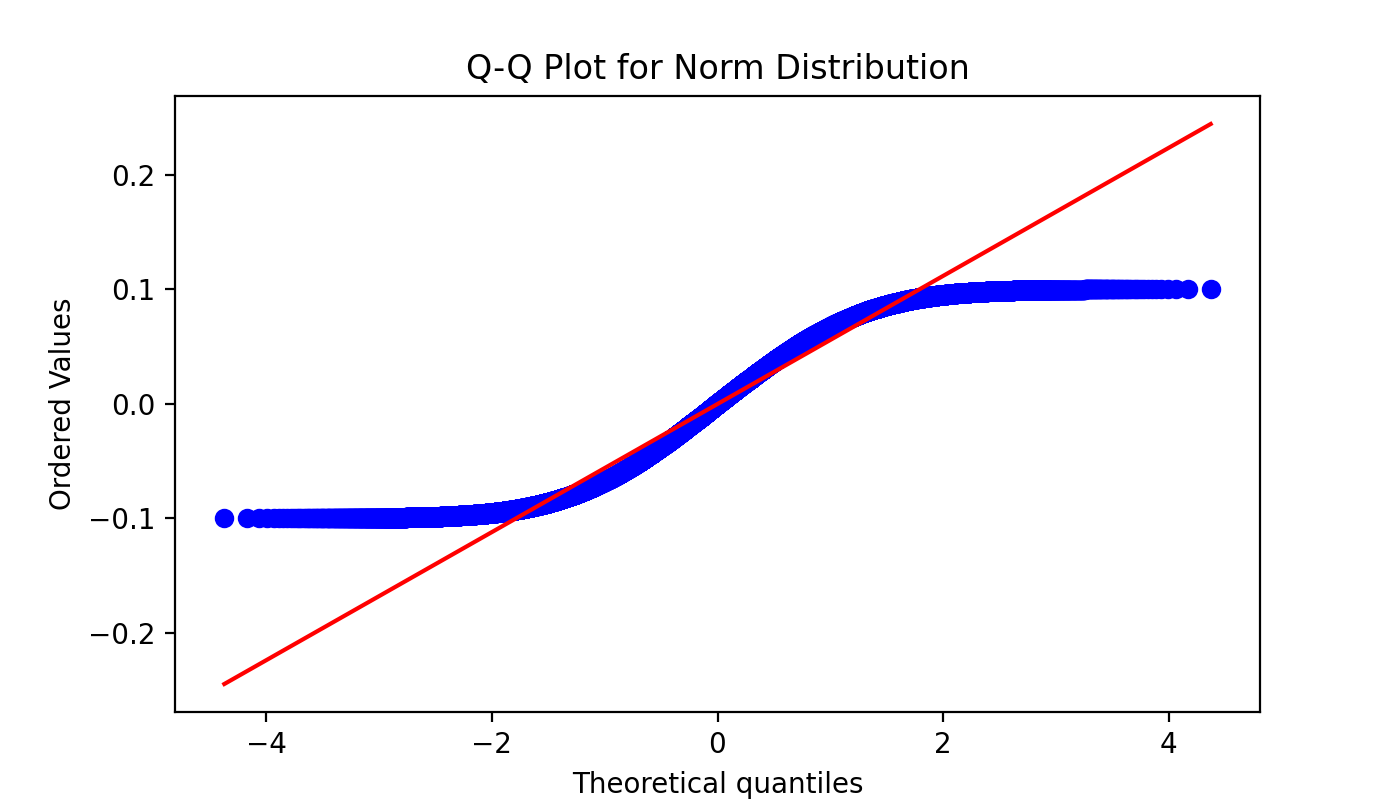

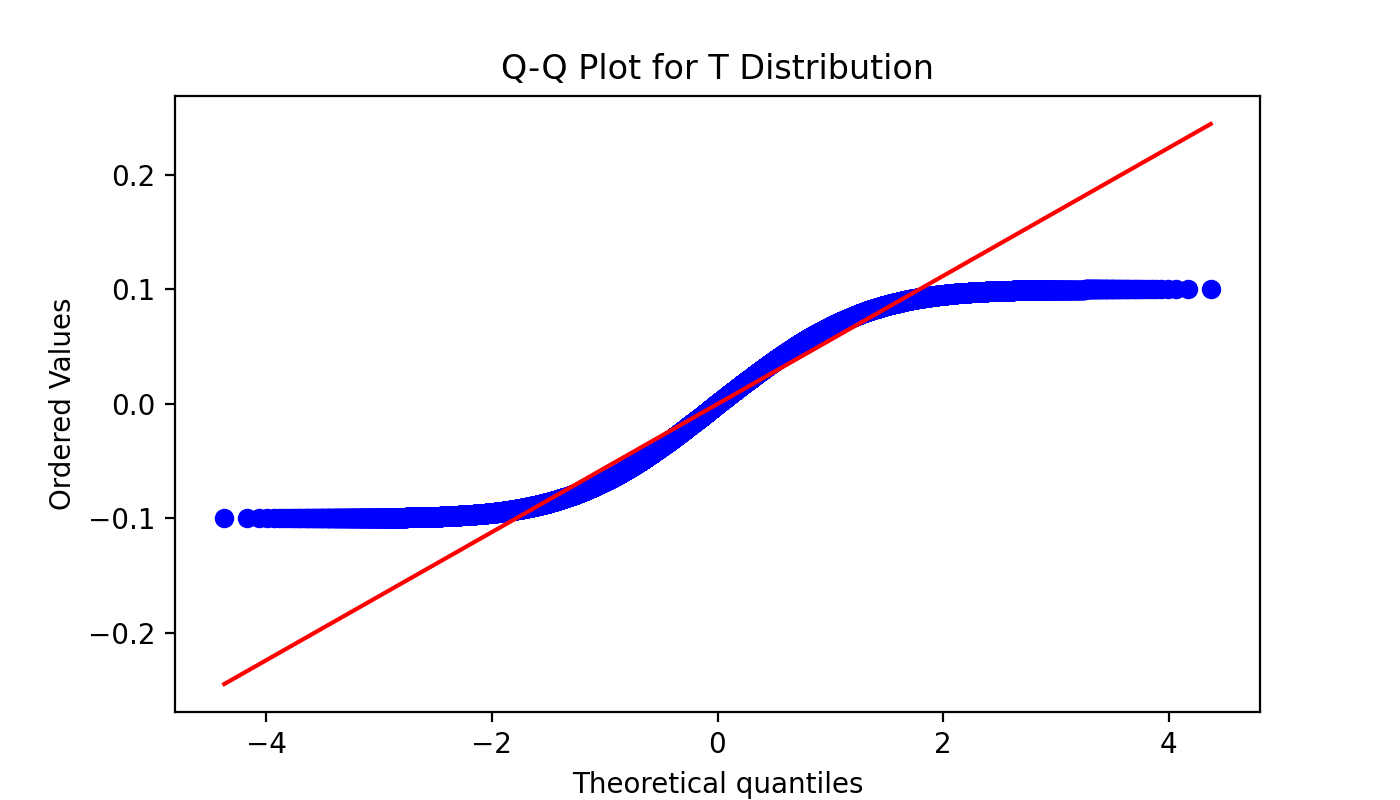

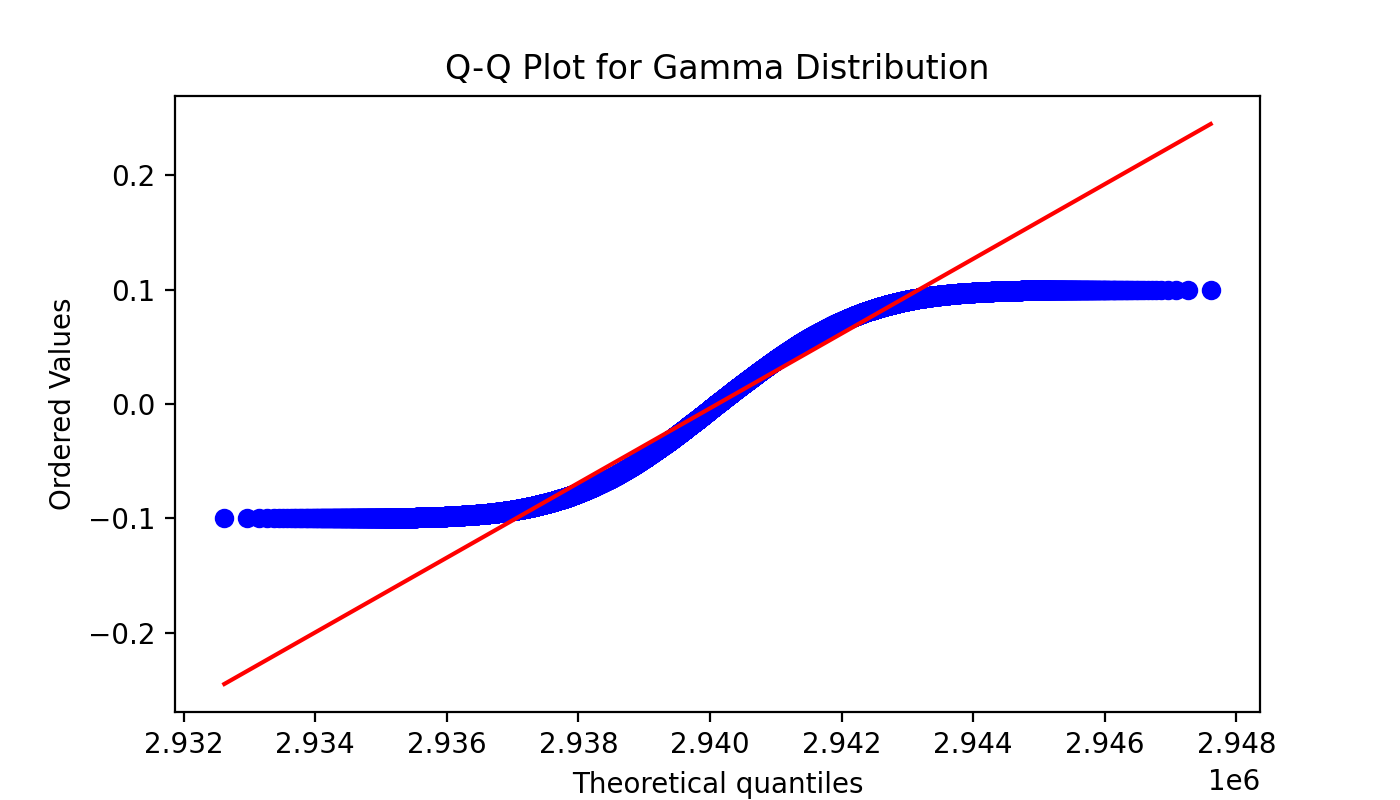

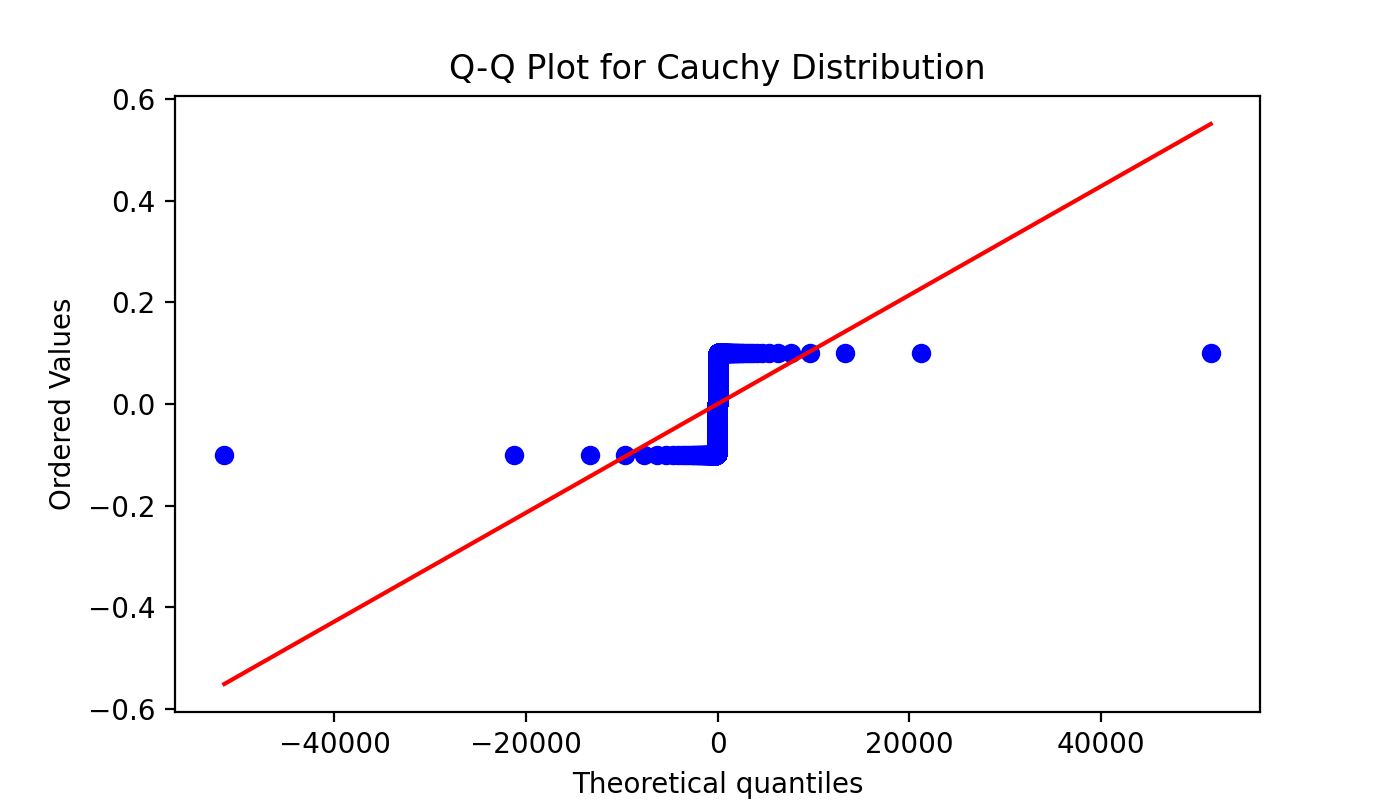

In [88]:
from scipy import stats
import matplotlib.pyplot as plt

# Assuming Y_train_np is your data
distributions = {
    'norm': stats.norm, 
    't': stats.t, 
    'gamma': stats.gamma, 
    'cauchy': stats.cauchy, 
    # Add other distributions as needed
}

for name, dist in distributions.items():
    # Fit the distribution to your data
    params = dist.fit(Y_train_np)
    
    # Generate Q-Q plot
    plt.figure(figsize=(7, 4))
    stats.probplot(Y_train_np, dist=name, sparams=params[:-2], plot=plt)
    plt.title(f'Q-Q Plot for {name.capitalize()} Distribution')
    plt.show()


este grafico apenas ve a distribuição da target variable?

In [89]:
from lightgbmlss.model import *
from lightgbmlss.distributions.Gaussian import *

dtrain = lgb.Dataset(X_train, label=Y_train.values)  # Convert to numpy array

lgblss = LightGBMLSS(
    Gaussian(stabilization="None",  
             response_fn="exp",      
             loss_fn="nll"          
            ))

param_dict = { 
    "max_depth":               ["int",   {"low": 1,    "high": 10,    "log": False}],
    "num_leaves":              ["int",   {"low": 2,    "high": 100,   "log": False}],  
    "min_data_in_leaf":        ["int",   {"low": 200,  "high": 200,   "log": False}],  
    "min_gain_to_split":       ["float", {"low": 1, "high": 40,    "log": False}],
    "min_sum_hessian_in_leaf": ["float", {"low": 1, "high": 500,   "log": True}],
    "subsample":               ["float", {"low": 0.2,  "high": 1.0,   "log": False}],
    "feature_fraction":        ["float", {"low": 0.2,  "high": 1.0,   "log": False}],
    "boosting":                ["numerical", ["dart", "goss", "gbdt"]],
}

np.random.seed(123)
opt_param = lgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=50,   # Number of early-stopping rounds
                             max_minutes=10,             # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=30 ,               # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=True,               # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=123                 # Seed for random number generator used in the Bayesian hyperparameter search.
                            )

  0%|          | 0/30 [00:00<?, ?it/s]

Best trial: 26. Best value: -32351.4: 100%|██████████| 30/30 [02:41<00:00,  5.39s/it, 161.75/600 seconds]


Hyper-Parameter Optimization successfully finished.
  Number of finished trials:  30
  Best trial:
    Value: -32351.434459430177
    Params: 
    max_depth: 9
    num_leaves: 62
    min_data_in_leaf: 200
    min_gain_to_split: 7.047677518065988
    min_sum_hessian_in_leaf: 14.93145857955459
    subsample: 0.738559989295958
    feature_fraction: 0.33992430611491287
    boosting: gbdt
    opt_rounds: 18


In [90]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
lgblss.train(opt_params, dtrain, num_boost_round=n_rounds)

# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 1000
quant_sel = [0.05, 0.95] # Quantiles to calculate from predicted distribution

# Sample from predicted distribution
pred_samples = lgblss.predict(X_test,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = lgblss.predict(X_test,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Return predicted distributional parameters
pred_params = lgblss.predict(X_test,
                             pred_type="parameters")

In [91]:
pred_samples.head()

y_sample0  y_sample1  y_sample2  y_sample3  y_sample4  y_sample5  \
0   0.019239   0.099071  -0.024362   0.058727   0.033432   0.031551   
1  -0.010421   0.146305   0.044164  -0.058823   0.041158  -0.012918   
2  -0.017635  -0.034955   0.042027  -0.003252  -0.091839  -0.014674   
3  -0.033849   0.012712   0.002099  -0.021111   0.054123  -0.066585   
4   0.019884  -0.055298  -0.063436   0.015542  -0.010034  -0.047024   

   y_sample6  y_sample7  y_sample8  y_sample9  ...  y_sample990  y_sample991  \
0   0.048777   0.041658  -0.006032  -0.002836  ...     0.006246    -0.120583   
1   0.091146   0.018776  -0.059893   0.038305  ...    -0.045726     0.028941   
2  -0.011662  -0.074766  -0.149201   0.113660  ...    -0.031507     0.008838   
3  -0.097181   0.059716  -0.003789  -0.031342  ...     0.070213     0.039733   
4  -0.030115   0.037011   0.033600  -0.018545  ...    -0.007623     0.023136   

   y_sample992  y_sample993  y_sample994  y_sample995  y_sample996  \
0     0.047269     0.023746    -0.013914    -0.014431    -0.059768   
1     0.039262    -0.067718    -0.083004    -0.057105     0.055509   
2    -0.012553    -0.058253     0.044679    -0.058163     0.163402   
3     0.024229    -0.031673     0.066269    -0.200880     0.027328   
4    -0.107850     0.071818     0.027121     0.117611    -0.068087   

   y_sample997  y_sample998  y_sample999  
0    -0.013180     0.083145     0.081288  
1    -0.008388    -0.027520     0.012927  
2     0.007135    -0.067868     0.042255  
3    -0.065028     0.024556     0.000527  
4     0.003491     0.049027    -0.010813  

[5 rows x 1000 columns]

In [92]:
pred_quantiles.head()

quant_0.05  quant_0.95
0   -0.093362    0.100177
1   -0.089388    0.101353
2   -0.091483    0.091662
3   -0.094768    0.093847
4   -0.095491    0.100238

In [93]:
pred_params.head()

loc     scale
0 -0.000115  0.057368
1 -0.000222  0.057368
2 -0.000222  0.057368
3 -0.000115  0.057368
4 -0.000115  0.057368

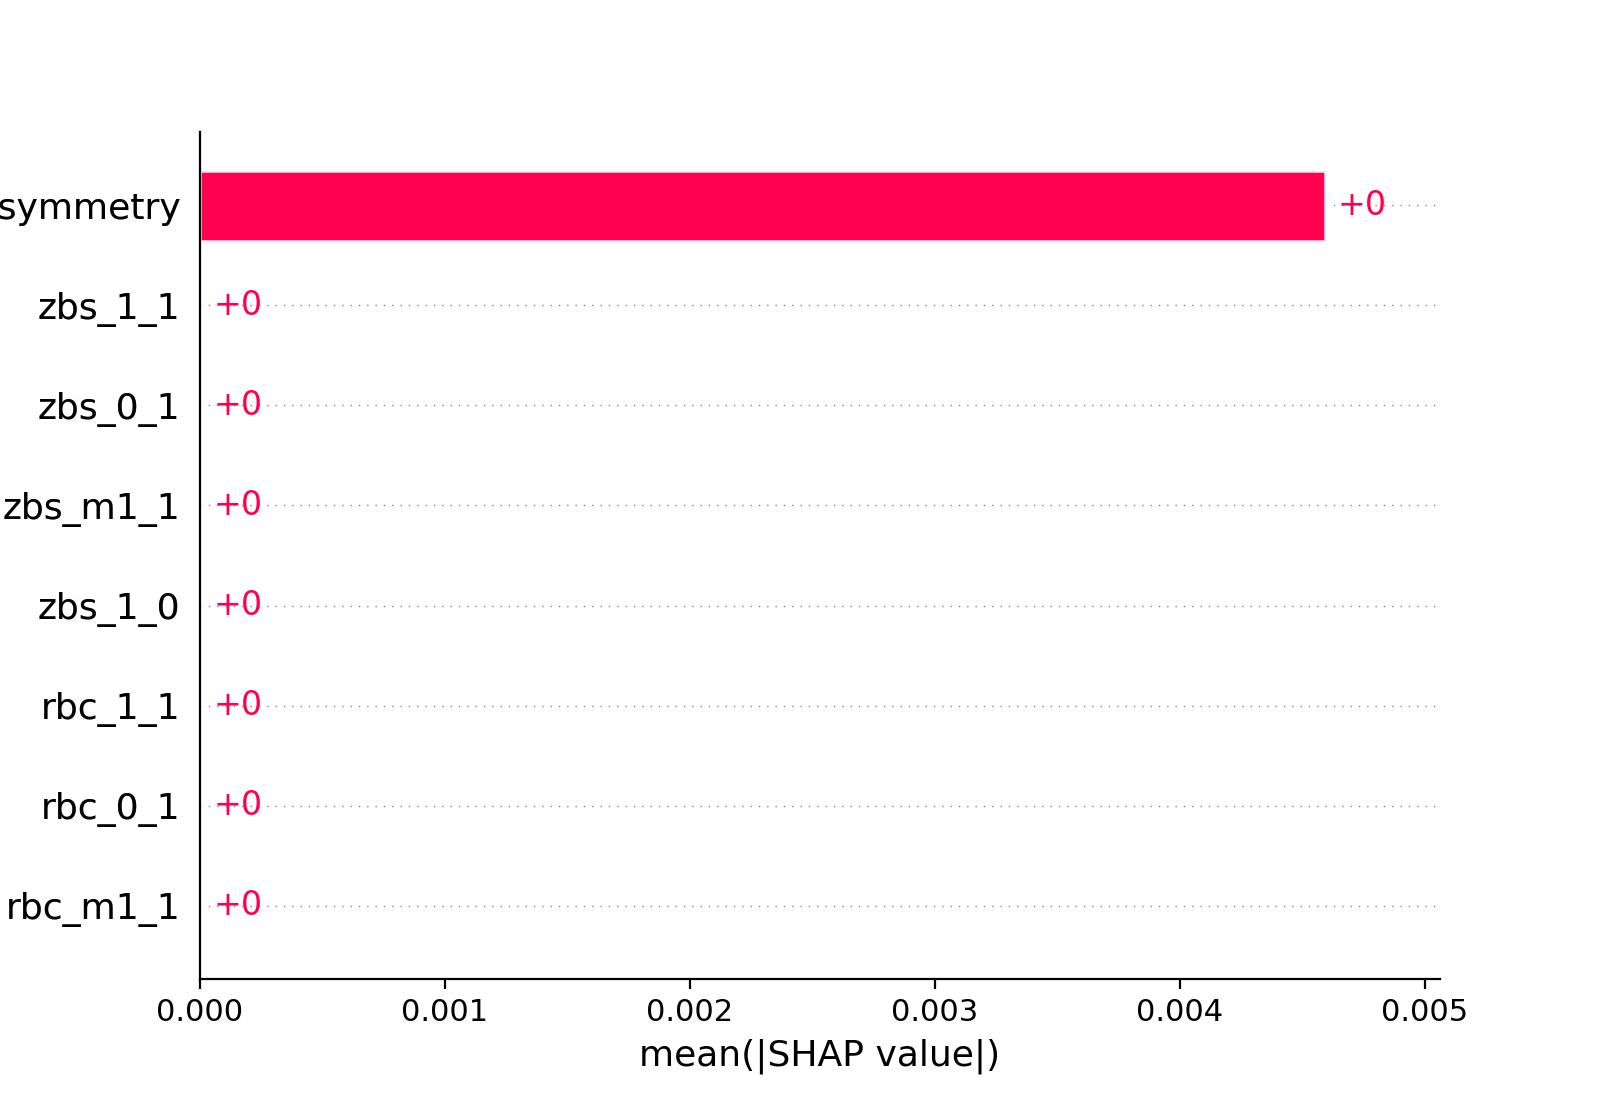

In [103]:
# Feature Importance of scale parameter
lgblss.plot(X_test,
            parameter="scale",
            plot_type="Feature_Importance")

In [95]:
# Assuming Y_test is your true values and pred_params contains mean and variance of the predictions
# Extract mean and variance
predicted_means = pred_params['loc']
predicted_variances = pred_params['scale']

# Calculate standard deviation from variance
predicted_std = np.sqrt(predicted_variances)

# Calculate Mean Absolute Error (MAE) as one option for mean error
mean_error = np.mean(np.abs(predicted_means - Y_test))

# For Mean Squared Error (MSE), use:
# mean_squared_error = np.mean((predicted_means - Y_test) ** 2)

# Output the results
print(f"Mean Error (MAE): {mean_error}")
print(f"Standard Deviation: {predicted_std.mean()}")  # Average standard deviation across all predictions

# Note: The calculation of standard deviation's average might need adjustments based on your specific requirements.


Mean Error (MAE): 0.04984538957395965
Standard Deviation: 0.23916560411453247


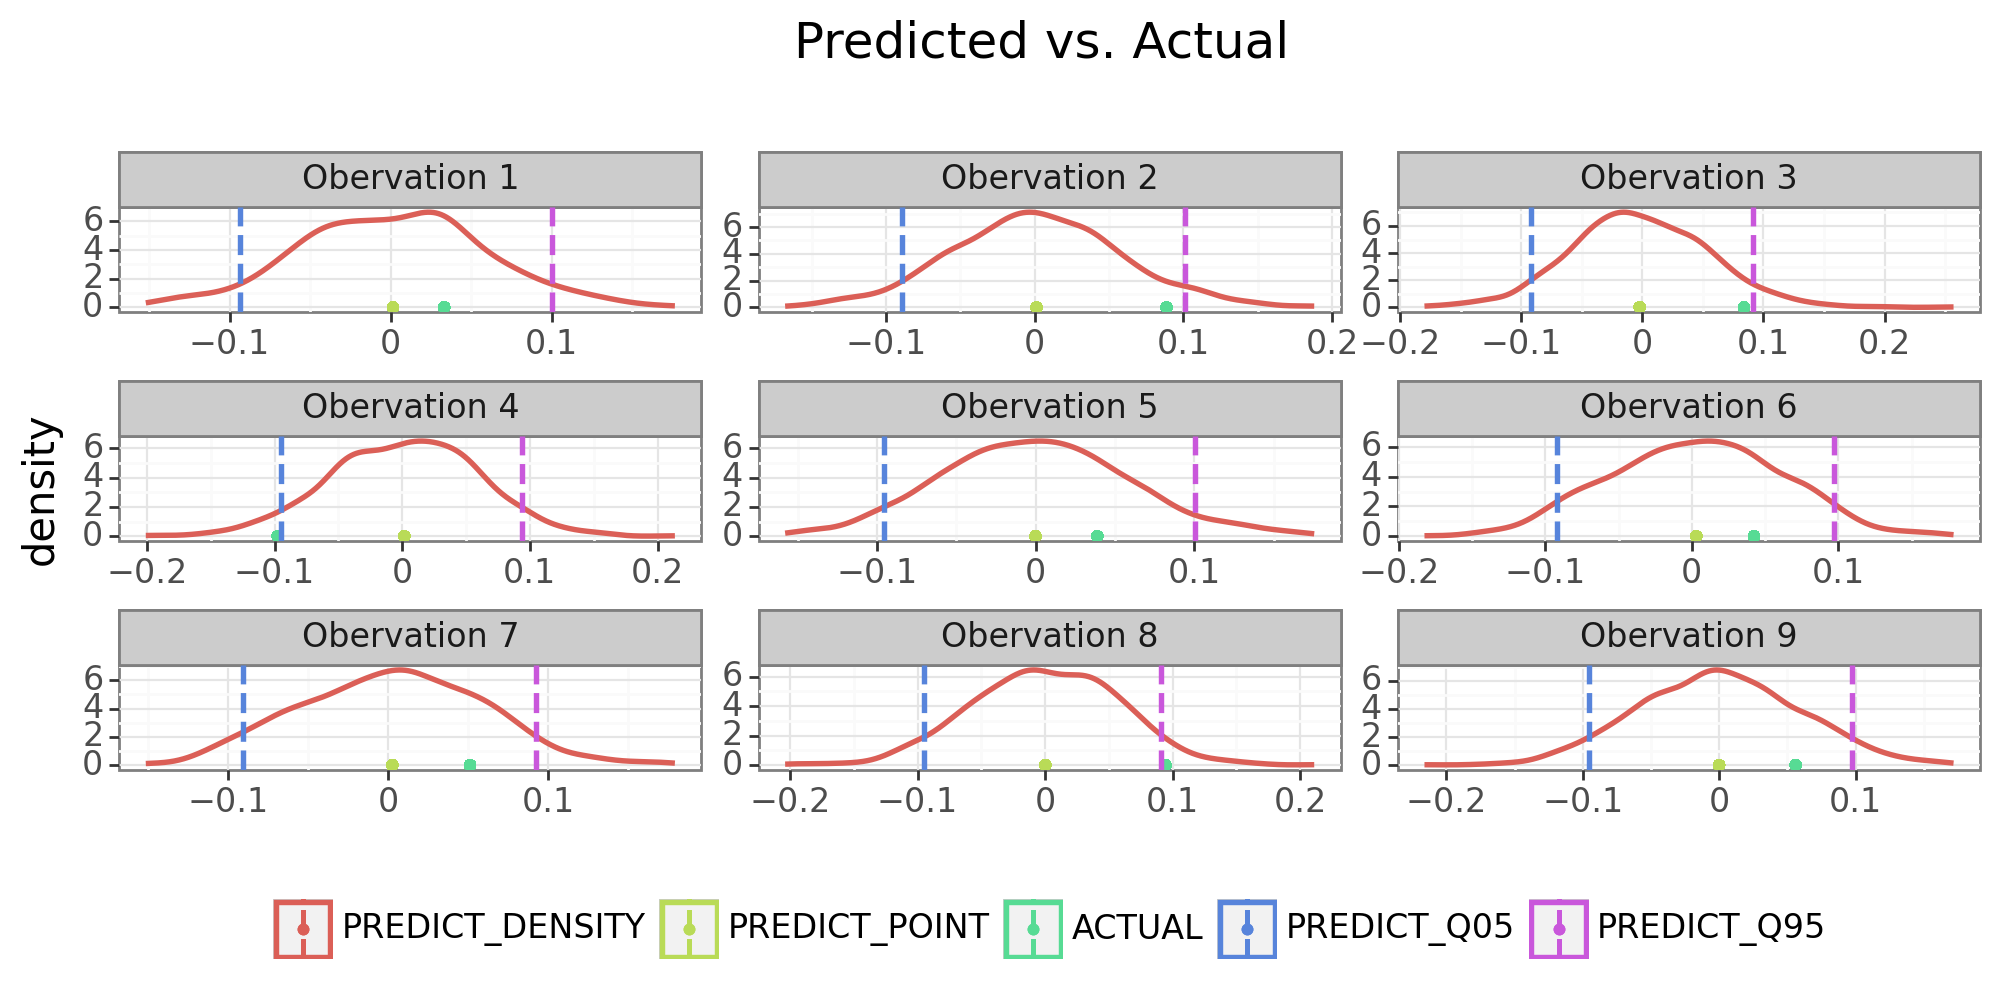

In [96]:
from plotnine import ggplot, aes, geom_point, geom_vline, stat_density, facet_wrap, labs, theme_bw, scale_fill_brewer, theme, element_text, element_blank

y_pred = []

n_examples = 9

for i in range(n_examples):    
    y_samples = pd.DataFrame(pred_samples.values[i,:].reshape(-1,1), columns=["PREDICT_DENSITY"])
    y_samples["PREDICT_POINT"] = y_samples["PREDICT_DENSITY"].mean()
    y_samples["PREDICT_Q05"] = y_samples["PREDICT_DENSITY"].quantile(q=quant_sel[0])
    y_samples["PREDICT_Q95"] = y_samples["PREDICT_DENSITY"].quantile(q=quant_sel[1])
    y_samples["ACTUAL"] = Y_test.iloc[i]
    y_samples["obs"]= f"Obervation {i+1}"
    y_pred.append(y_samples)
    
pred_df = pd.melt(pd.concat(y_pred, axis=0), id_vars="obs")
pred_df["obs"] = pd.Categorical(pred_df["obs"], categories=[f"Obervation {i+1}" for i in range(n_examples)])
df_actual, df_pred_dens, df_pred_point, df_q05, df_q95 = [x for _, x in pred_df.groupby("variable")]

plot_pred = (
    ggplot(pred_df,
           aes(color="variable")) + 
    stat_density(df_pred_dens,
                 aes(x="value"),
                 size=1.1) + 
    geom_point(df_pred_point,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_point(df_actual,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_vline(df_q05, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    geom_vline(df_q95, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    facet_wrap("obs",
               scales="free",
               ncol=3) + 
    labs(title="Predicted vs. Actual \n",
         x = "") + 
    theme_bw(base_size=15) +
    scale_fill_brewer(type="qual", palette="Dark2") + 
    theme(legend_position="bottom",
          plot_title = element_text(hjust = 0.5),
          legend_title = element_blank()
         )
)

print(plot_pred)

UMAP WITH FEATURES AND MEAN ERROR

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/pynndescent/pynndescent_.py:962: UserWarning: Failed to correctly find n_neighbors for some samples. Results may be less than ideal. Try re-running with different parameters.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/umap/umap_.py:126: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = inf has removed 18485 edges.
It has only fully disconnected 69 vertices.
Use umap.utils.disconnected_vertices() to identify them.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.


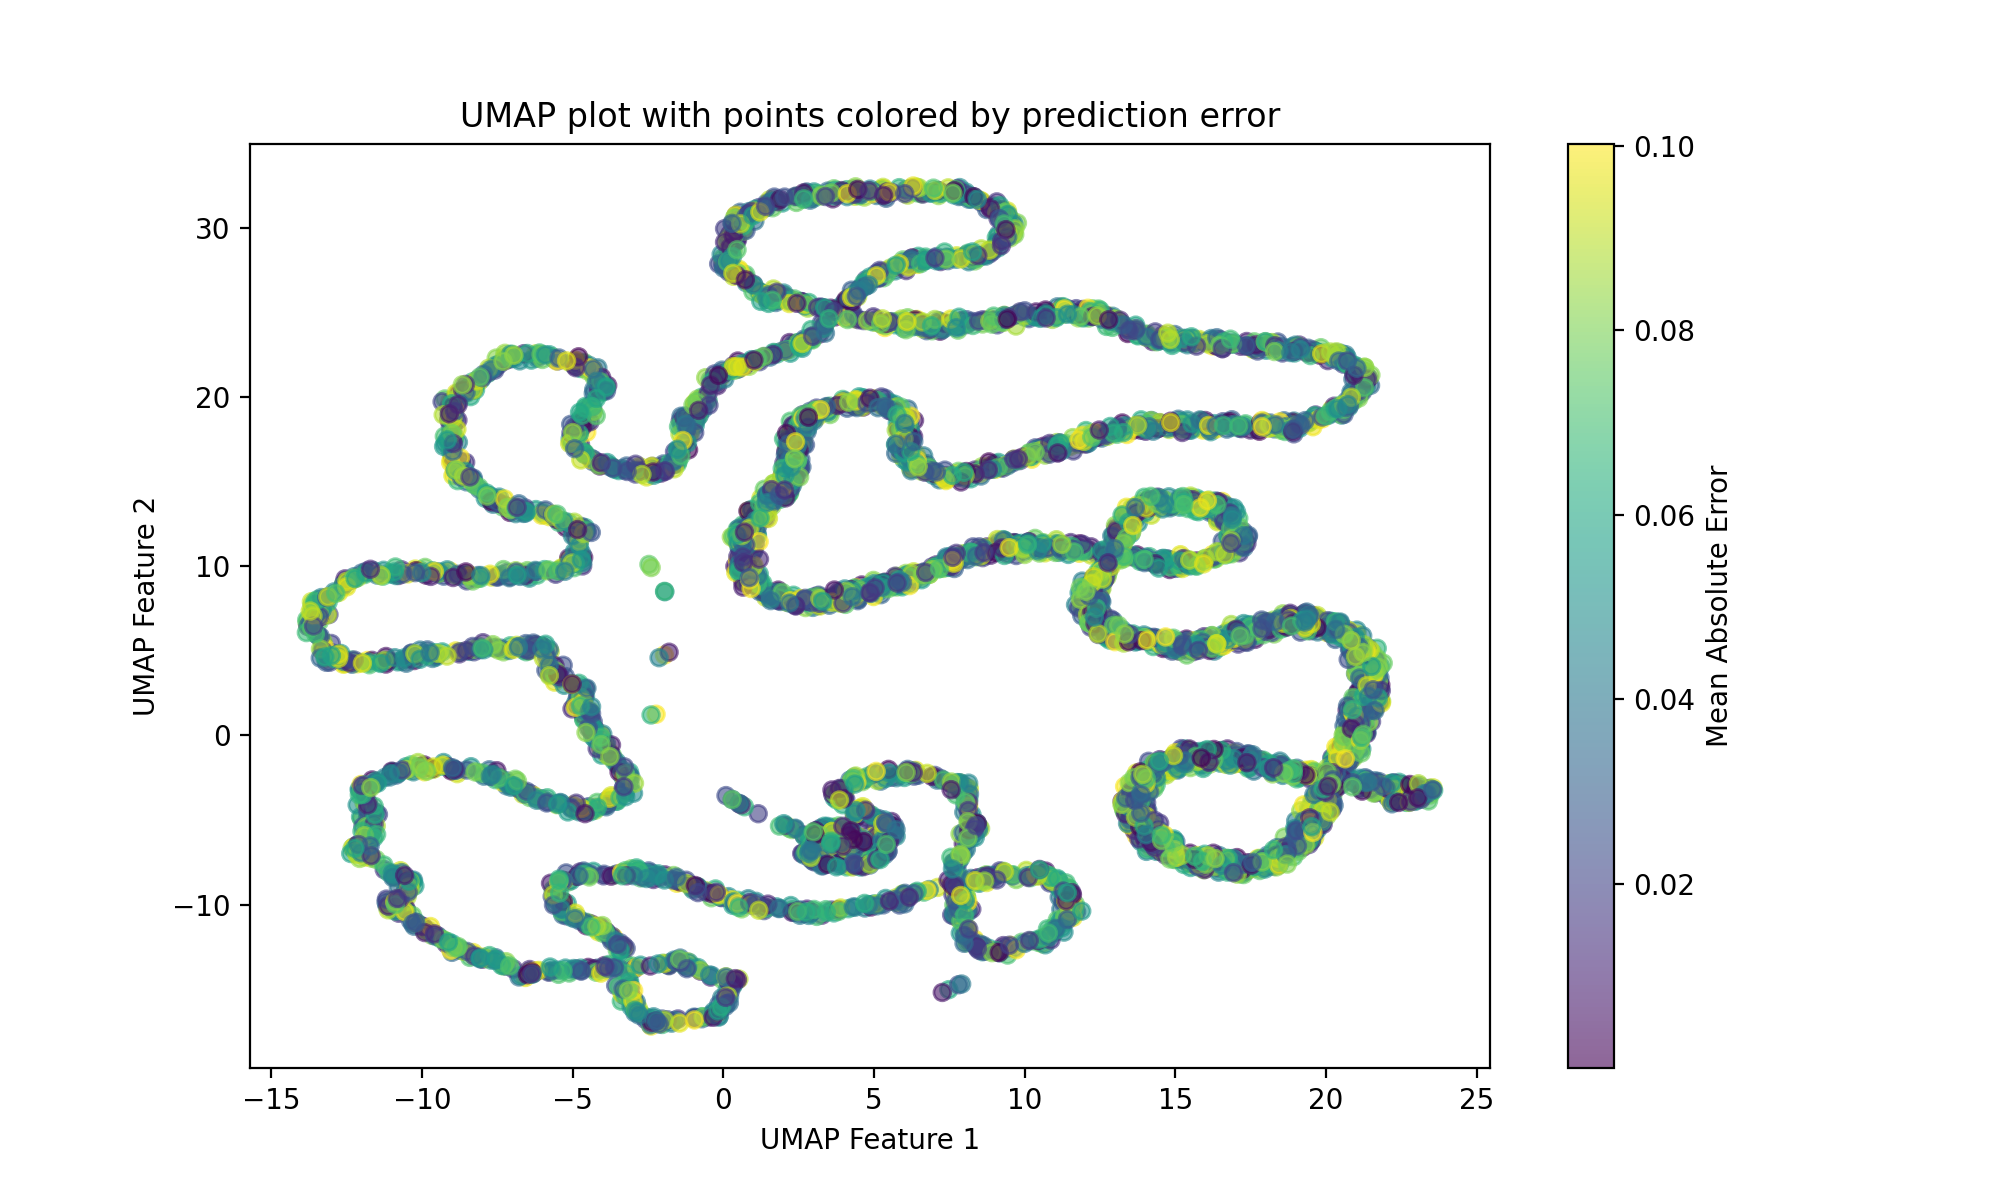

In [97]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import umap

# Calculate the absolute error for each prediction
absolute_errors = np.abs(predicted_means - Y_test)

# Combine the features and the errors into one DataFrame for t-SNE/UMAP
tsne_features = X_test.copy()
tsne_features['absolute_error'] = absolute_errors

# Replace inf/-inf with NaN
tsne_features.replace([np.inf, -np.inf], np.nan, inplace=True)

# Option 1: Drop rows with NaNs (if they were inf/-inf)
tsne_features.dropna(inplace=True)


# Initialize UMAP. You can adjust n_neighbors and min_dist as needed.
reducer = umap.UMAP(n_neighbors=200, min_dist=1, n_components=2, random_state=42)

# Fit and transform the features (excluding the 'absolute_error' column)
embedding = reducer.fit_transform(tsne_features.drop('absolute_error', axis=1))

# Now, let's create the plot using UMAP results
plt.figure(figsize=(10,6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=tsne_features['absolute_error'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Mean Absolute Error')
plt.title('UMAP plot with points colored by prediction error')
plt.xlabel('UMAP Feature 1')
plt.ylabel('UMAP Feature 2')
plt.show()


UMAP WITH FEATURES AND STD

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


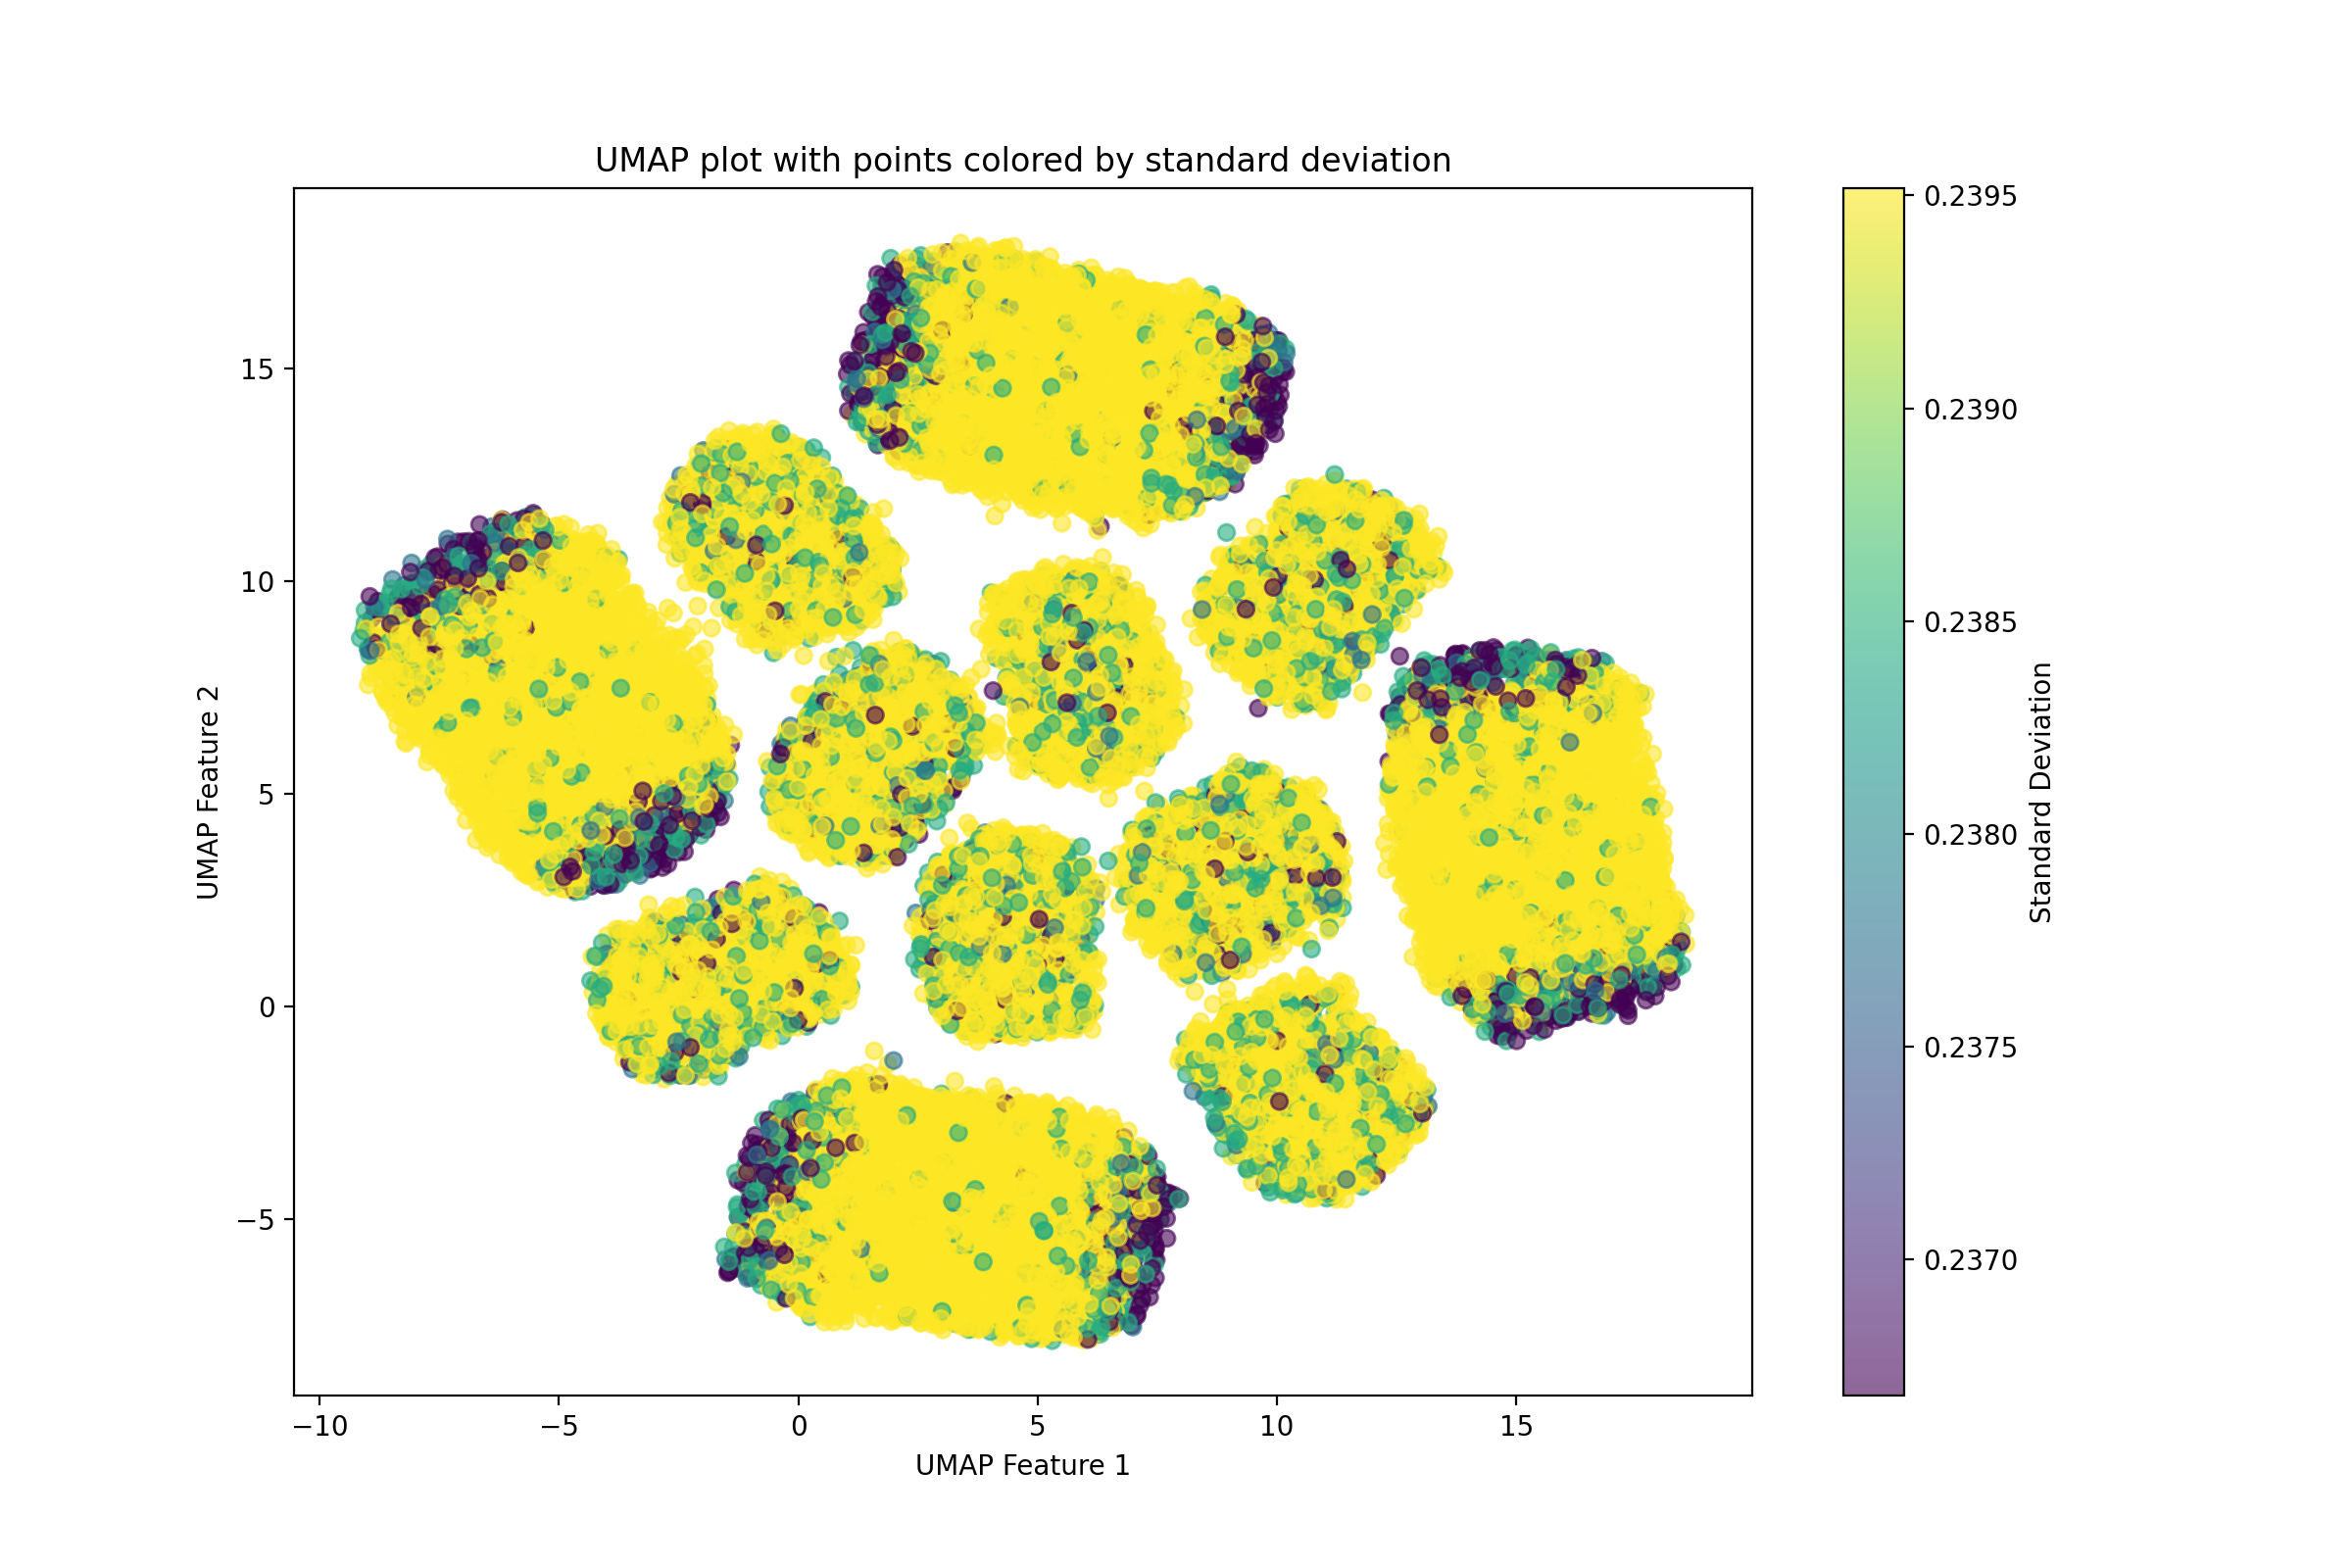

In [98]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Replace inf/-inf with NaN in your features
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check if there are any NaN values and handle them
if X_test.isnull().values.any():
    # Impute the NaNs or drop the rows/columns with NaN values.
    # Here we impute with the mean, but you might want to consider other imputation methods
    X_test = X_test.fillna(X_test.mean())

# Ensure no infinite values in predicted_variances before calculating the standard deviation
predicted_variances = np.where(np.isfinite(predicted_variances), predicted_variances, np.nan)
predicted_variances = np.nan_to_num(predicted_variances, nan=np.nanmean(predicted_variances))
predicted_std = np.sqrt(predicted_variances)

# Normalize your features to ensure they don't contain too large values
scaler = MinMaxScaler()
X_test_scaled = scaler.fit_transform(X_test)

# Combine the scaled features and the standard deviations into one DataFrame for UMAP
umap_features = pd.DataFrame(X_test_scaled, columns=X_test.columns)
umap_features['std_dev'] = predicted_std

# Initialize UMAP. You can adjust n_neighbors and min_dist as needed.
reducer = umap.UMAP(n_neighbors=200, min_dist=1, n_components=2, random_state=42)

# Fit and transform the features (excluding the 'std_dev' column)
embedding = reducer.fit_transform(umap_features.drop('std_dev', axis=1))

# Now, let's create the plot using UMAP results
plt.figure(figsize=(12,8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=umap_features['std_dev'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Standard Deviation')
plt.title('UMAP plot with points colored by standard deviation')
plt.xlabel('UMAP Feature 1')
plt.ylabel('UMAP Feature 2')
plt.show()


UMAP WITH TARGET AND MEAN ERROR

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/pynndescent/pynndescent_.py:962: UserWarning: Failed to correctly find n_neighbors for some samples. Results may be less than ideal. Try re-running with different parameters.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/umap/umap_.py:126: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = inf has removed 18482 edges.
It has only fully disconnected 69 vertices.
Use umap.utils.disconnected_vertices() to identify them.
/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.


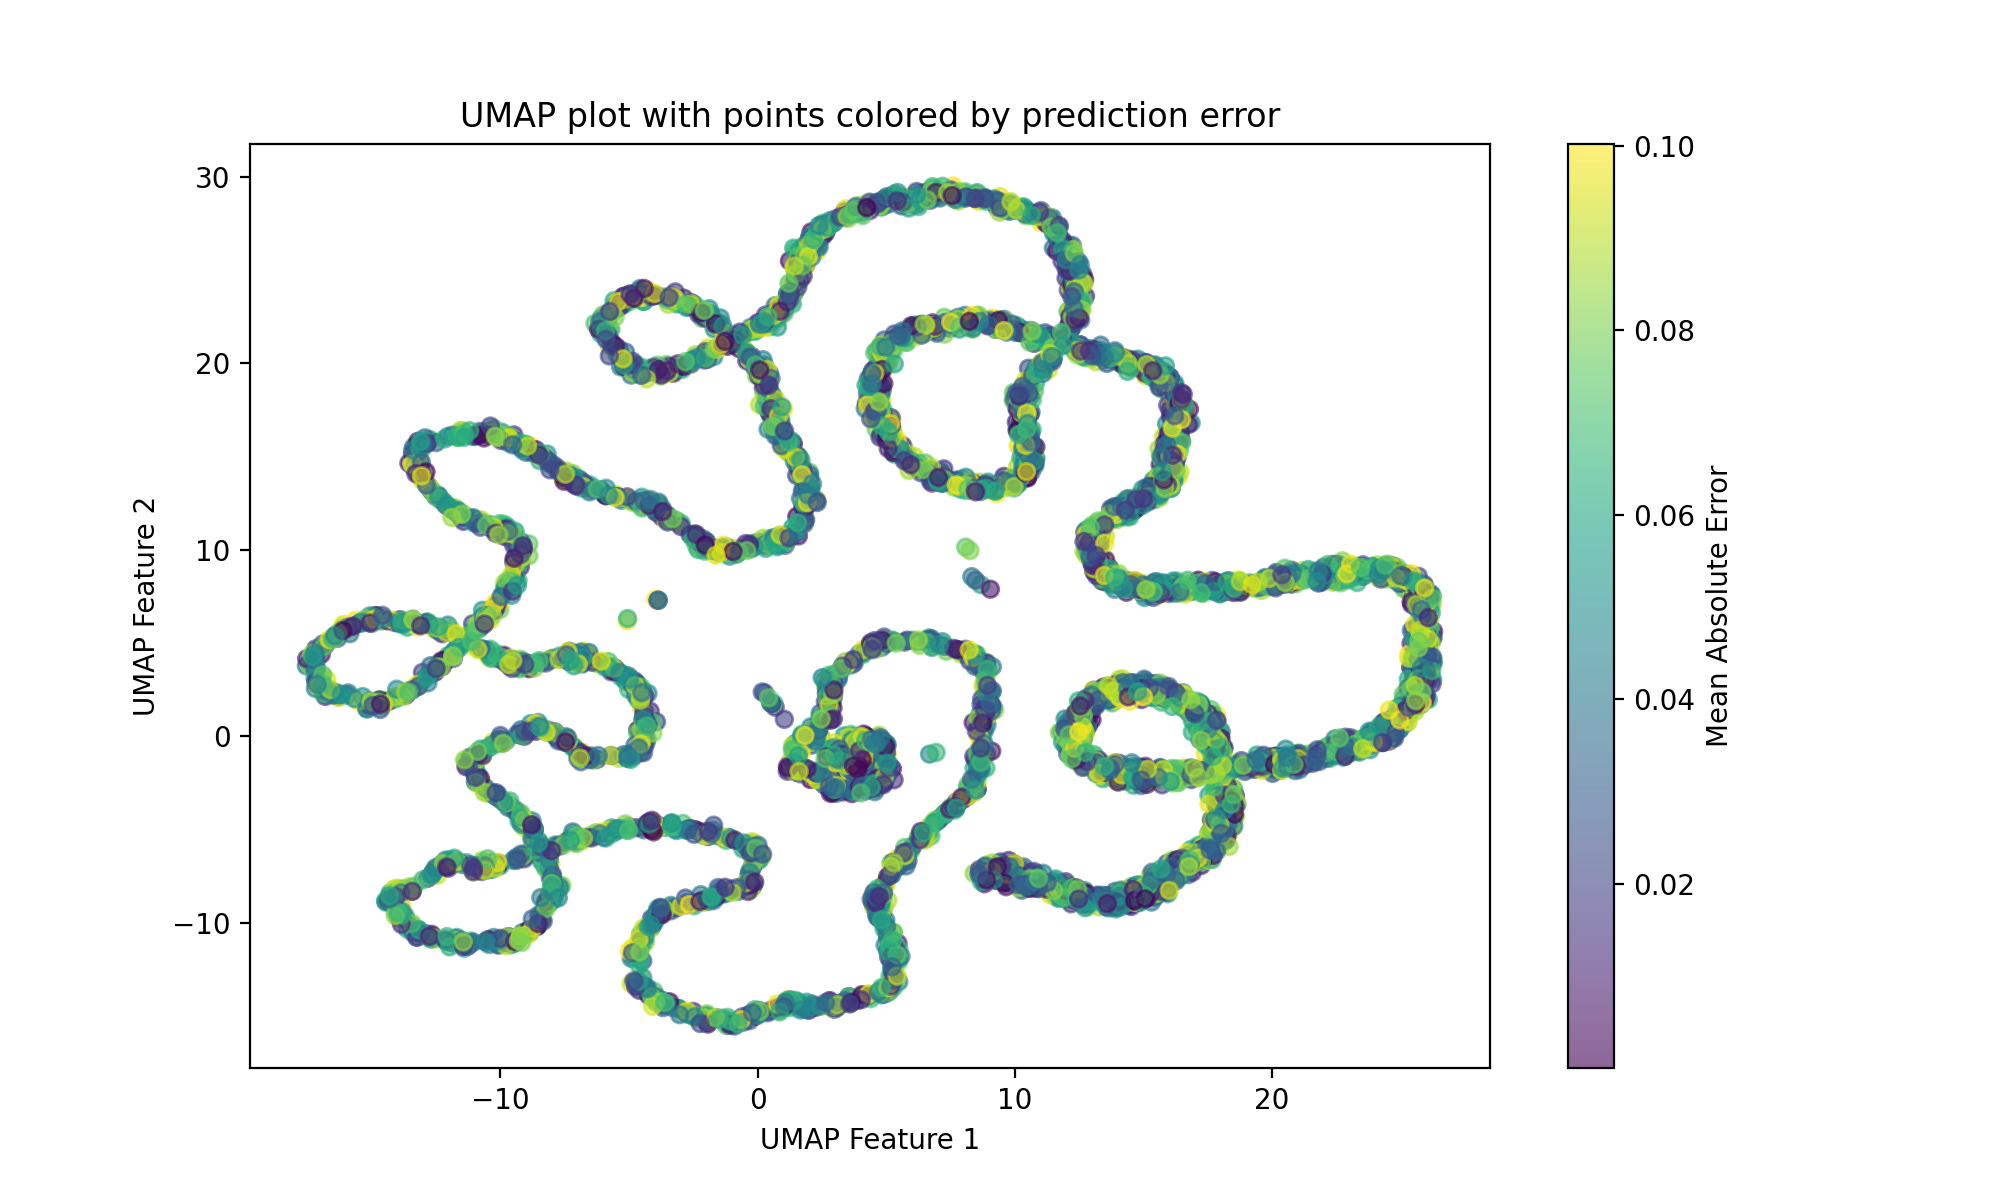

In [99]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import umap

# Calculate the absolute error for each prediction
absolute_errors = np.abs(predicted_means - Y_test)
f_t = pd.concat([X_test, Y_test], axis=1)

# Combine the features and the errors into one DataFrame for t-SNE/UMAP
tsne_features = f_t.copy()
tsne_features['absolute_error'] = absolute_errors

# Replace inf/-inf with NaN
tsne_features.replace([np.inf, -np.inf], np.nan, inplace=True)

# Option 1: Drop rows with NaNs (if they were inf/-inf)
tsne_features.dropna(inplace=True)


# Initialize UMAP. You can adjust n_neighbors and min_dist as needed.
reducer = umap.UMAP(n_neighbors=200, min_dist=1, n_components=2, random_state=42)

# Fit and transform the features (excluding the 'absolute_error' column)
embedding = reducer.fit_transform(tsne_features.drop('absolute_error', axis=1))

# Now, let's create the plot using UMAP results
plt.figure(figsize=(10,6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=tsne_features['absolute_error'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Mean Absolute Error')
plt.title('UMAP plot with points colored by prediction error')
plt.xlabel('UMAP Feature 1')
plt.ylabel('UMAP Feature 2')
plt.show()


UMAP WITH TARGET AND STD

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


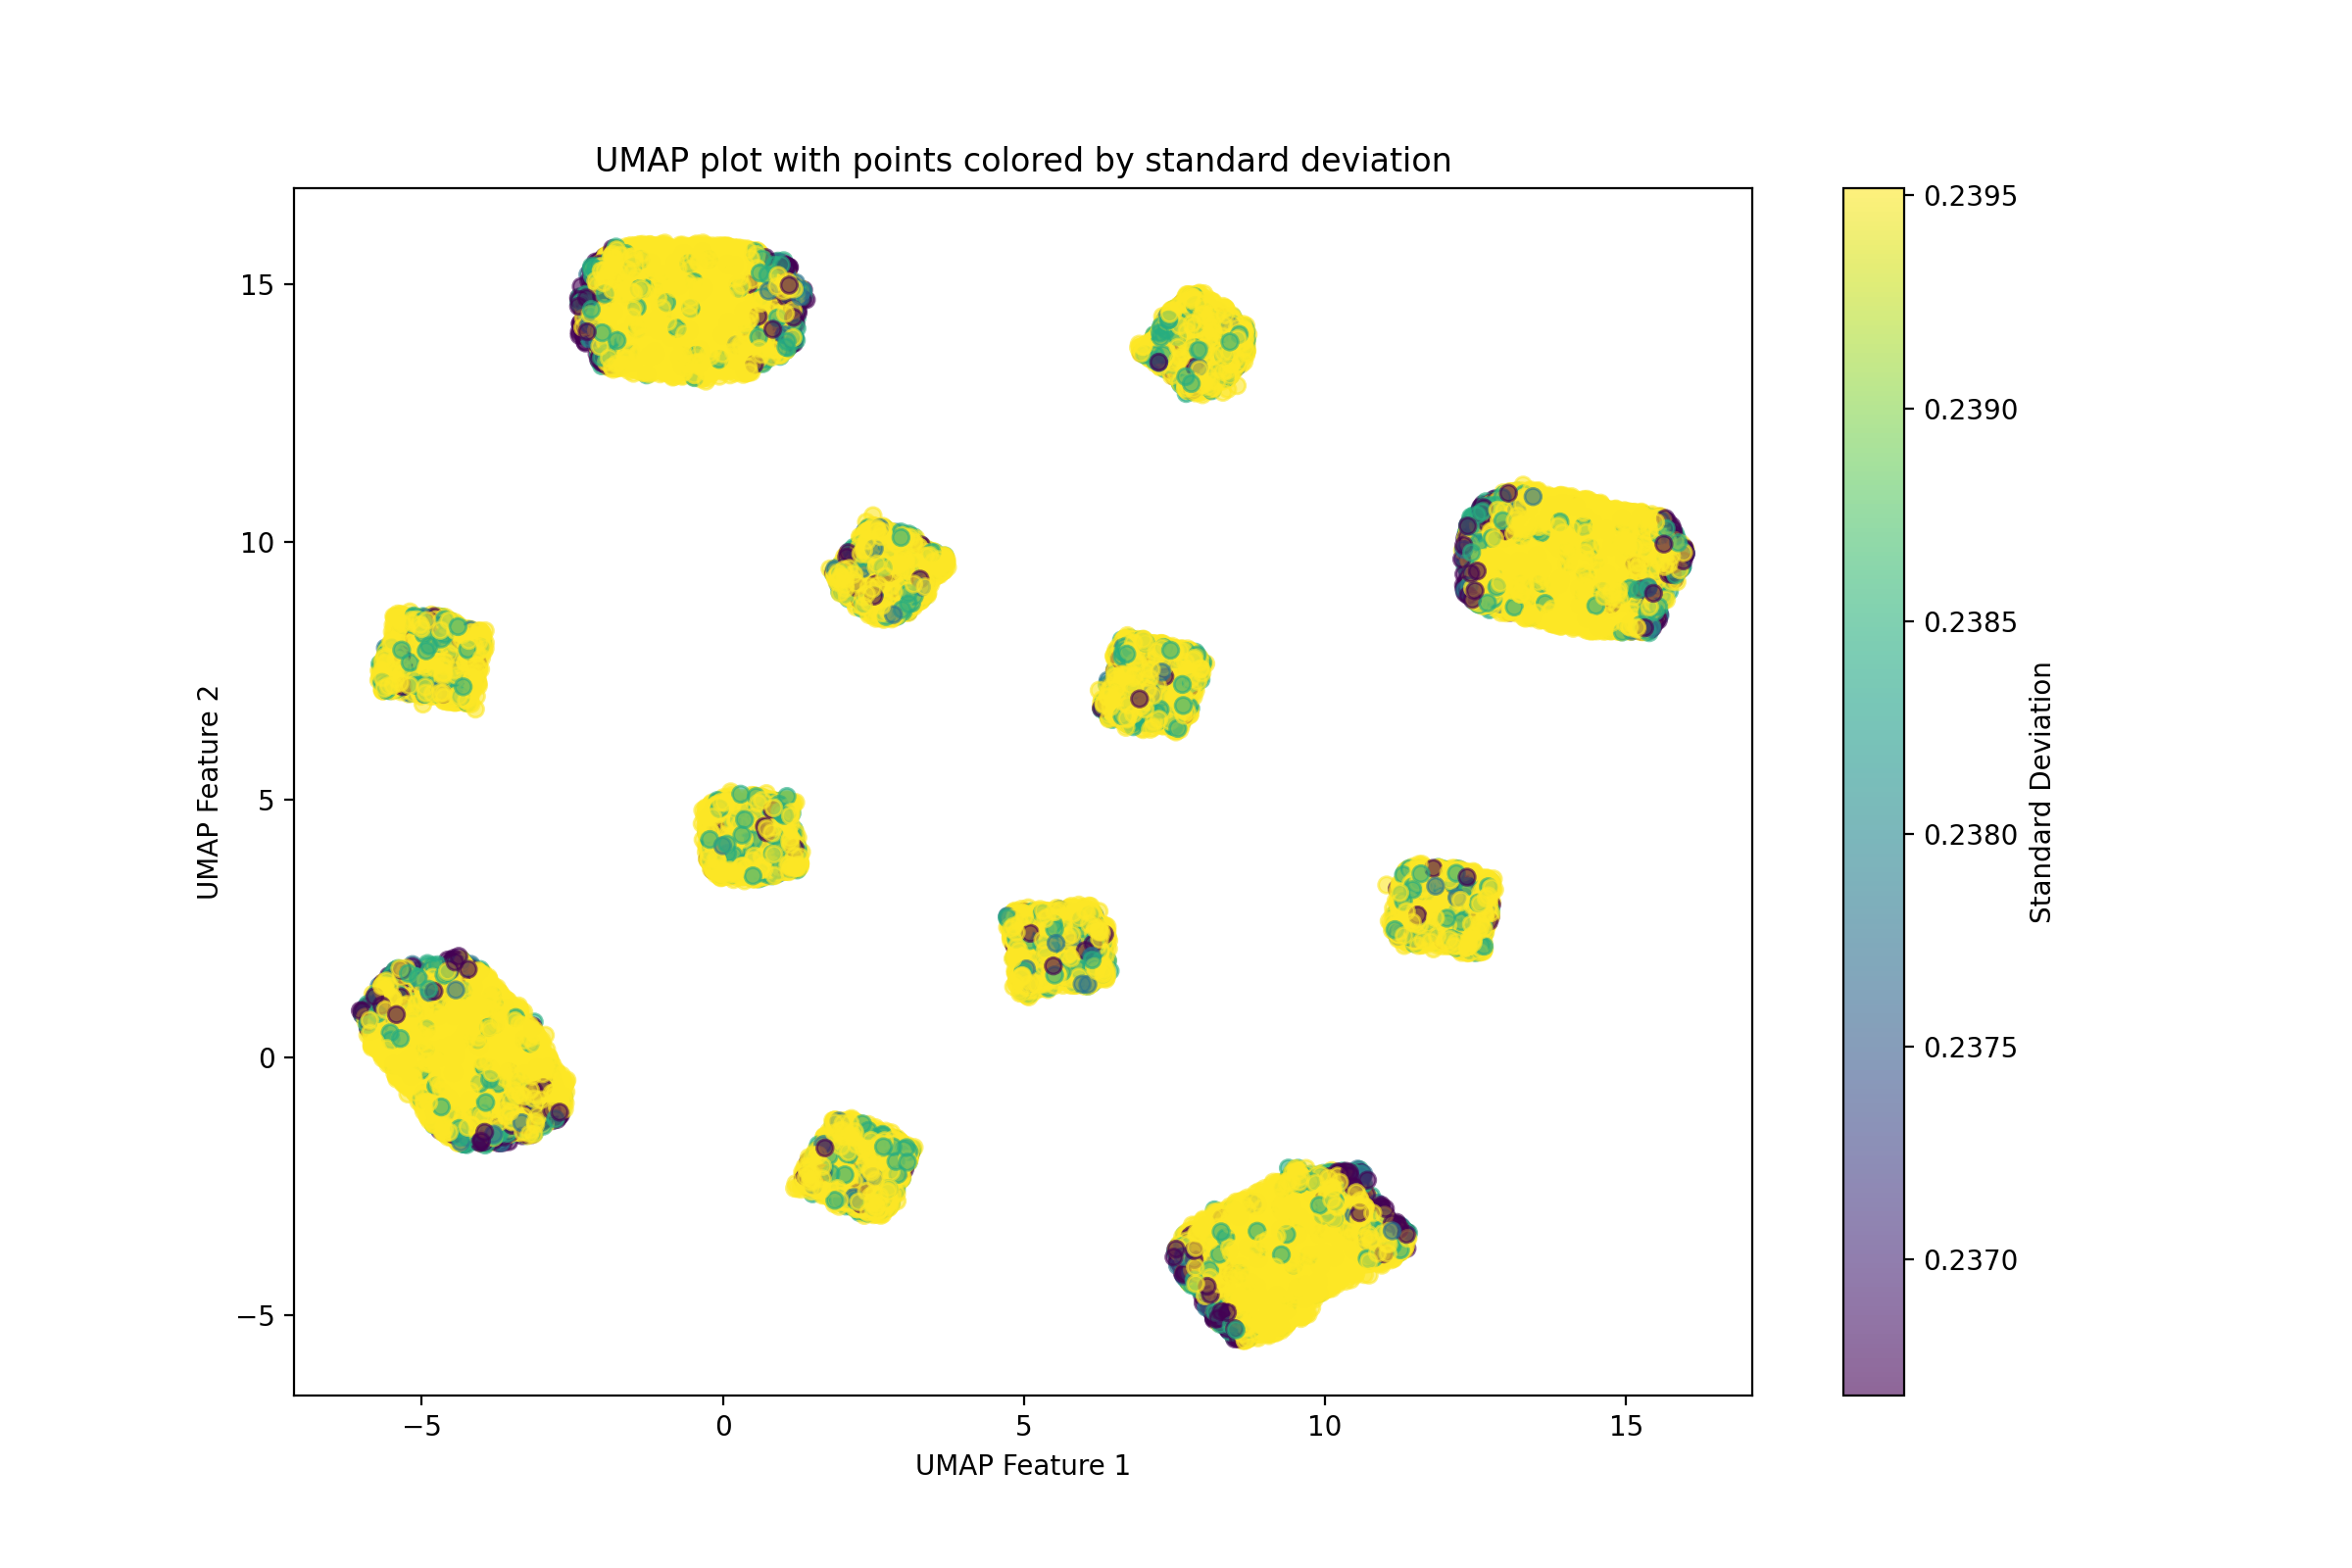

In [100]:
# Assuming `X_test` and `Y_test` are pandas DataFrames and `predicted_variances` is a numpy array

# Replace inf/-inf with NaN and then drop or impute NaN values for both X_test and Y_test
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
Y_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Assuming you want to impute NaN values, do it for both
X_test = X_test.fillna(X_test.mean())
Y_test = Y_test.fillna(Y_test.mean())

# Combine X_test and Y_test into a single DataFrame
combined_data = pd.concat([X_test, Y_test], axis=1)

# Normalize your features to ensure they don't contain too large values
scaler = MinMaxScaler()
combined_data_scaled = scaler.fit_transform(combined_data)

# Combine the scaled features into one DataFrame for UMAP
umap_features = pd.DataFrame(combined_data_scaled, columns=combined_data.columns)

# Initialize UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)

# Fit and transform the features
embedding = reducer.fit_transform(umap_features)

# Ensure no infinite values in predicted_variances before calculating the standard deviation
predicted_variances = np.where(np.isfinite(predicted_variances), predicted_variances, np.nan)
predicted_variances = np.nan_to_num(predicted_variances, nan=np.nanmean(predicted_variances))
predicted_std = np.sqrt(predicted_variances)

# Add standard deviation to the UMAP features for coloring the plot
umap_features['std_dev'] = predicted_std

# Now, let's create the plot using UMAP results
plt.figure(figsize=(12,8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=umap_features['std_dev'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Standard Deviation')
plt.title('UMAP plot with points colored by standard deviation')
plt.xlabel('UMAP Feature 1')
plt.ylabel('UMAP Feature 2')
plt.show()
